# Contrastive learning experimentations

https://github.com/lucidrains/byol-pytorch - BYOL and SimSiam

https://github.com/jacobgil/pytorch-grad-cam

https://github.com/kiraving/SegGradCAM

https://wandb.ai/wandb/wandb-lightning/reports/Image-Classification-using-PyTorch-Lightning--VmlldzoyODk1NzY

## Setup

In [ ]:
!nvidia-smi

Tue Aug 23 10:58:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     8W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install byol-pytorch pytorch-lightning grad-cam --quiet

     |████████████████████████████████| 705 kB 9.0 MB/s 
     |████████████████████████████████| 7.8 MB 29.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 419 kB 46.4 MB/s 
     |████████████████████████████████| 5.9 MB 56.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.


In [ ]:
!pip install hub urllib3==1.26.7 --quiet

     |████████████████████████████████| 402 kB 8.3 MB/s 
     |████████████████████████████████| 138 kB 53.9 MB/s 
     |████████████████████████████████| 132 kB 65.7 MB/s 
     |████████████████████████████████| 76 kB 6.5 MB/s 
     |████████████████████████████████| 6.6 MB 25.6 MB/s 
     |████████████████████████████████| 9.1 MB 52.9 MB/s 
     |████████████████████████████████| 79 kB 7.9 MB/s 
     |████████████████████████████████| 115 kB 25.6 MB/s 
     |████████████████████████████████| 52 kB 1.0 MB/s 
     |████████████████████████████████| 62 kB 515 kB/s 


## Imports

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path

import cv2
import numpy as np

import hub
import torch
import torchmetrics
import pytorch_lightning as pl
from byol_pytorch import BYOL
from torchvision import models
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import CIFAR10, Places365, ImageNet, VOCDetection
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image

from pytorch_grad_cam import ScoreCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

44

In [ ]:
class args:
    use_cuda = True
    models_dir = Path("/content/drive/MyDrive/Trabalho/Fruitpunch/AI for damage inspection/models/")

## Load data

In [ ]:
train_ds = hub.load('hub://luizapzbn/CODEBRIM_classification_dataset-train')
val_ds = hub.load('hub://luizapzbn/CODEBRIM_classification_dataset-val')
test_ds = hub.load('hub://luizapzbn/CODEBRIM_classification_dataset-test')

hub://luizapzbn/CODEBRIM_classification_dataset-train loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/luizapzbn/CODEBRIM_classification_dataset-train
hub://luizapzbn/CODEBRIM_classification_dataset-val loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/luizapzbn/CODEBRIM_classification_dataset-val
hub://luizapzbn/CODEBRIM_classification_dataset-test loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/luizapzbn/CODEBRIM_classification_dataset-test


In [ ]:
train_ds.visualize()

 * Serving Flask app "dataset_visualizer" (lazy loading)


 * Environment: production


In [ ]:
tform = transforms.Compose([
    transforms.ToTensor(), # Must convert to pytorch tensor for subsequent operations to run
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                     std=[0.229, 0.224, 0.225])
])

class_names = ["Background", "Crack", "Spallation", "Efflorescence", "ExposedBars", "CorrosionStain"]
num_classes = len(class_names)

tform_labels = lambda x: F.one_hot(torch.Tensor(x).to(torch.int64), num_classes=num_classes).squeeze(0)
batch_size = 32

train_loader = train_ds.pytorch(num_workers = 0, shuffle = True, transform = {'images': tform, 'labels': tform_labels}, batch_size = batch_size)
val_loader = val_ds.pytorch(num_workers = 0, shuffle = True, transform = {'images': tform, 'labels': tform_labels}, batch_size = batch_size)
test_loader = test_ds.pytorch(num_workers = 0, shuffle = True, transform = {'images': tform, 'labels': tform_labels}, batch_size = batch_size)

In [ ]:
imgs, labels = next(iter(train_loader))
grid = make_grid(imgs, ncols=4)
img = transforms.ToPILImage()(grid)
img

In [ ]:
labels.shape

torch.Size([32, 6])

## Classification tasks

### Binary Classification

In [ ]:
!pip install transformers datasets --quiet

     |████████████████████████████████| 4.7 MB 8.6 MB/s 
     |████████████████████████████████| 365 kB 68.8 MB/s 
     |████████████████████████████████| 101 kB 12.7 MB/s 
     |████████████████████████████████| 6.6 MB 42.8 MB/s 
     |████████████████████████████████| 212 kB 71.6 MB/s 


In [ ]:
import torchvision
from transformers import AutoModelForImageClassification

# https://pytorch-lightning.readthedocs.io/en/stable/notebooks/lightning_examples/text-transformers.html
# https://huggingface.co/docs/transformers/training
# https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification
# https://huggingface.co/docs/transformers/v4.21.1/en/model_doc/convnext#transformers.ConvNextForImageClassification
# https://medium.com/mlearning-ai/make-powerful-deep-learning-models-quickly-using-pytorch-lightning-29f040158ef3

In [ ]:
class Classifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.accuracy = torchmetrics.Accuracy()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=5e-5)
        sch = torch.optim.lr_scheduler.StepLR(
                optimizer, step_size=10, gamma = 0.5)
        #learning rate scheduler
        return {
            "optimizer": optimizer,
            "lr_scheduler" : {
                "scheduler" : sch,
                "monitor" : "train_loss",
                
            }
        }

    def forward(self, x, y):
        out = self.model(x, y)
        return out.logits, out.loss

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits, loss = self(x, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits, loss = self(x, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, logger=True)

    def predict(self, x):
        logits, loss = self(x, y)
        preds = torch.argmax(logits, dim=1)
        return preds

In [ ]:
model = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224", num_labels=1000)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

classifier = Classifier(model)
finetune_trainer = pl.Trainer(accelerator='gpu', devices=1, precision=16, max_epochs=20, log_every_n_steps=10)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
finetune_trainer.fit(classifier, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type                           | Params
------------------------------------------------------------
0 | model    | ConvNextForImageClassification | 27.8 M
1 | accuracy | Accuracy                       | 0     
------------------------------------------------------------
27.8 M    Trainable params
0         Non-trainable params
27.8 M    Total params
55.649    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:179: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  "Your `IterableDataset` has `__len__` defined."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:133: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  "Your `IterableDataset` has `__len__` defined."


ValueError: ignored

## Contrastive Training

In [ ]:
class ContrastiveLearner(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=3e-4)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        loss = self.model(x)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        loss = self.model(x)
        self.log('val_loss', loss)

    def return_embedding(self, images):
        projection, embedding = self.model(images, return_embedding = True)
        return projection, embedding

In [ ]:
load_weights = False

resnet = models.resnet50(weights=True)
# SimSiam setup
byol = BYOL(
    resnet,
    image_size = 256,
    hidden_layer = 'avgpool',
    use_momentum = False
)

# model
model = ContrastiveLearner(model=byol)

if load_weights:
    print("Loading state dict")
    model.load_state_dict(
        torch.load(args.models_dir / "byol_codebrim.pt")
    )

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer = pl.Trainer(accelerator='gpu', devices=1, precision=16, max_epochs=50)
trainer.fit(model, train_loader)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:119: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | BYOL | 53.9 M
-------------------------------
53.9 M    Trainable params
0         Non-trainable params
53.9 M    Total params
107.795   Total estimat

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:121: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  "Your `IterableDataset` has `__len__` defined."
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
torch.save(
    model.state_dict(),
    args.models_dir / "byol_codebrim.pt"
)

## Finetune to targets

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    for param in model.parameters():
        if feature_extracting:
            param.requires_grad = False
        else:
            param.requires_grad = True

In [ ]:
load_weights = True

resnet = models.resnet50(weights=True)
# SimSiam setup
byol = BYOL(
    resnet,
    image_size = 256,
    hidden_layer = 'avgpool',
    use_momentum = False
)

# model
model = ContrastiveLearner(model=byol)

if load_weights:
    print("Loading state dict")
    model.load_state_dict(
        torch.load(args.models_dir / "byol_codebrim.pt")
    )

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading state dict


In [ ]:
class Finetuner(pl.LightningModule):
    def __init__(self, feature_extractor, num_classes):
        super().__init__()
        self.feature_extractor = feature_extractor
        set_parameter_requires_grad(self.feature_extractor, feature_extracting=True)

        # add classifier layer
        self.classifier = nn.Linear(in_features=2048, out_features=num_classes, bias=True)
        self.model = nn.Sequential(self.feature_extractor, self.classifier)

        self.accuracy = torchmetrics.Accuracy()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=3e-4)
        return optimizer

    def forward(self, x):
        projection, embedding = self.feature_extractor(x, return_embedding=True)
        x = F.log_softmax(self.classifier(embedding), dim=1)
        return x

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y = y.reshape(-1)
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y = y.reshape(-1)
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, logger=True)

    def predict(self, x):
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        return preds
        
    def return_embedding(self, images):
        projection, embedding = self.feature_extractor(images, return_embedding = True)
        return projection, embedding

In [ ]:
class_names = ["Background", "Crack", "Spallation", "Efflorescence", "ExposedBars", "CorrosionStain"]
finetuner = Finetuner(feature_extractor=model.model, num_classes=len(class_names))
finetune_trainer = pl.Trainer(accelerator='gpu', devices=1, precision=16, max_epochs=20, log_every_n_steps=10)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
finetune_trainer.fit(finetuner, val_loader, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | BYOL       | 53.9 M
1 | classifier        | Linear     | 12.3 K
2 | model             | Sequential | 53.9 M
3 | accuracy          | Accuracy   | 0     
-------------------------------------------------
12.3 K    Trainable params
53.9 M    Non-trainable params
53.9 M    Total params
107.820   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:167: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  "Your `IterableDataset` has `__len__` defined."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:121: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  "Your `IterableDataset` has `__len__` defined."


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
imgs, labels = next(iter(test_loader))
labels = labels.reshape(-1)
preds = finetuner.predict(imgs)
finetuner.accuracy(preds, labels)

tensor(0.4375)

## ScoreCAM visualization after finetuning

In [ ]:
set_parameter_requires_grad(finetuner.model, False)
target_layers = [finetuner.model[0].online_encoder.net.layer4[-1]]
input_tensor = imgs[0:2]

# Construct the CAM object once, and then re-use it on many images:
cam = ScoreCAM(model=finetuner, target_layers=target_layers, use_cuda=args.use_cuda)
# targets = [ClassifierOutputTarget(x) for x in labels.numpy()]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=None)

100%|██████████| 128/128 [00:08<00:00, 14.67it/s]


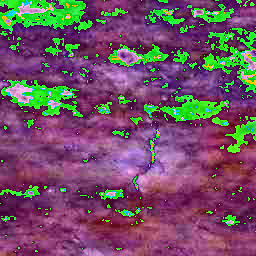

In [ ]:
idx = 0
grayscale_img = grayscale_cam[idx, :, :]
rgb_img = np.transpose(imgs[idx].numpy(), (1, 2, 0))
visualization = show_cam_on_image(rgb_img, grayscale_img, use_rgb=True)
img = Image.fromarray(visualization, 'RGB')
img

### TODO
- [ ] Contrastive train for a lot longer
- [ ] Show metrics after finetuning
- [ ] Add our dataset here to see performance after finetuning
- [ ] See what scorecam finds in our dataset
- [ ] Unnormalize image to visualize cam result 
- [ ] If promising, do a "segmentation" based on score cam output 
- [ ] Integrate with wandb